# Gradient boosting benchmarking

In [1]:
from __future__ import print_function, division

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import misc

/home/lemaitre/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Load the data as `DataFrame`

In [2]:
# Read the benchmark data
data_skl_leaf_presort = misc.load_benchmark_data('results/skl_leaf_with_presort_random.pk')
data_skl_leaf = misc.load_benchmark_data('results/skl_leaf_without_presort_random.pk')
data_skl_depth_presort = misc.load_benchmark_data('results/skl_depth_with_presort_random.pk')
data_skl_depth = misc.load_benchmark_data('results/skl_depth_without_presort_random.pk')

data_xgb_exact = misc.load_benchmark_data('results/xgboost_exact_random.pk')
data_xgb_approx_local = misc.load_benchmark_data('results/xgboost_approx_local_random.pk')
data_xgb_approx_global = misc.load_benchmark_data('results/xgboost_approx_global_random.pk')

data_lgb = misc.load_benchmark_data('results/lightgbm_random.pk', True)

# Group the data in a single list
data_bench = [data_skl_leaf, data_skl_depth, data_skl_leaf_presort, data_skl_depth_presort,
              data_xgb_exact, data_xgb_approx_local, data_xgb_approx_global,
              data_lgb]

## Average fitting time analysis

### Data pre-processing

From the different dataset, select only the the average time column and the variables.

In [3]:
# Define which columns need to be selected
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
# Select the columns
for idx_bench in range(len(data_bench)):
    data_bench[idx_bench] = data_bench[idx_bench].loc[:, col_to_select]
# Rename the column of the time
bench_name = ['sklearn-leaf', 'sklearn-depth', 'sklearn-leaf-presort', 'sklearn-depth-presort',
              'xgboost-exact', 'xgboost-approx-local', 'xgboost-approx-global',
              'lightgbm']
for i in range(len(bench_name)):
    data_bench[i] = data_bench[i].rename(columns = {'avg_fit_time': bench_name[i]})

Merge all the `DataFrame` in a single one.

In [4]:
# The name of the column to use for the merging
key_merging = ['num_samples', 'num_features', 'max_depth', 'n_estimators']
# Merge the two first bench - keep only the intersection
df_bench = pd.merge(data_bench[0], data_bench[1], on=key_merging, how='inner')
for i in np.arange(2, len(bench_name)):
    df_bench = pd.merge(df_bench, data_bench[i], on=key_merging, how='inner')

### Grouping the data and plots

We need to group the data using the four previous variable of interest for making clean plots.

In [5]:
# Define a plotting function to allow easy tight plot
def pd_df_barh(ax, df, name_params,fontsize=8):
    df.plot.barh(ax=ax, legend=False)
    ax.set_xlabel('Time in seconds', fontsize=fontsize)
    ax.set_ylabel('max-depth', fontsize=fontsize)
    ax.set_title('{} S - {} F - {} E'.format(*name_params),
                fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
    patches, labels = ax.get_legend_handles_labels()
    return patches, labels

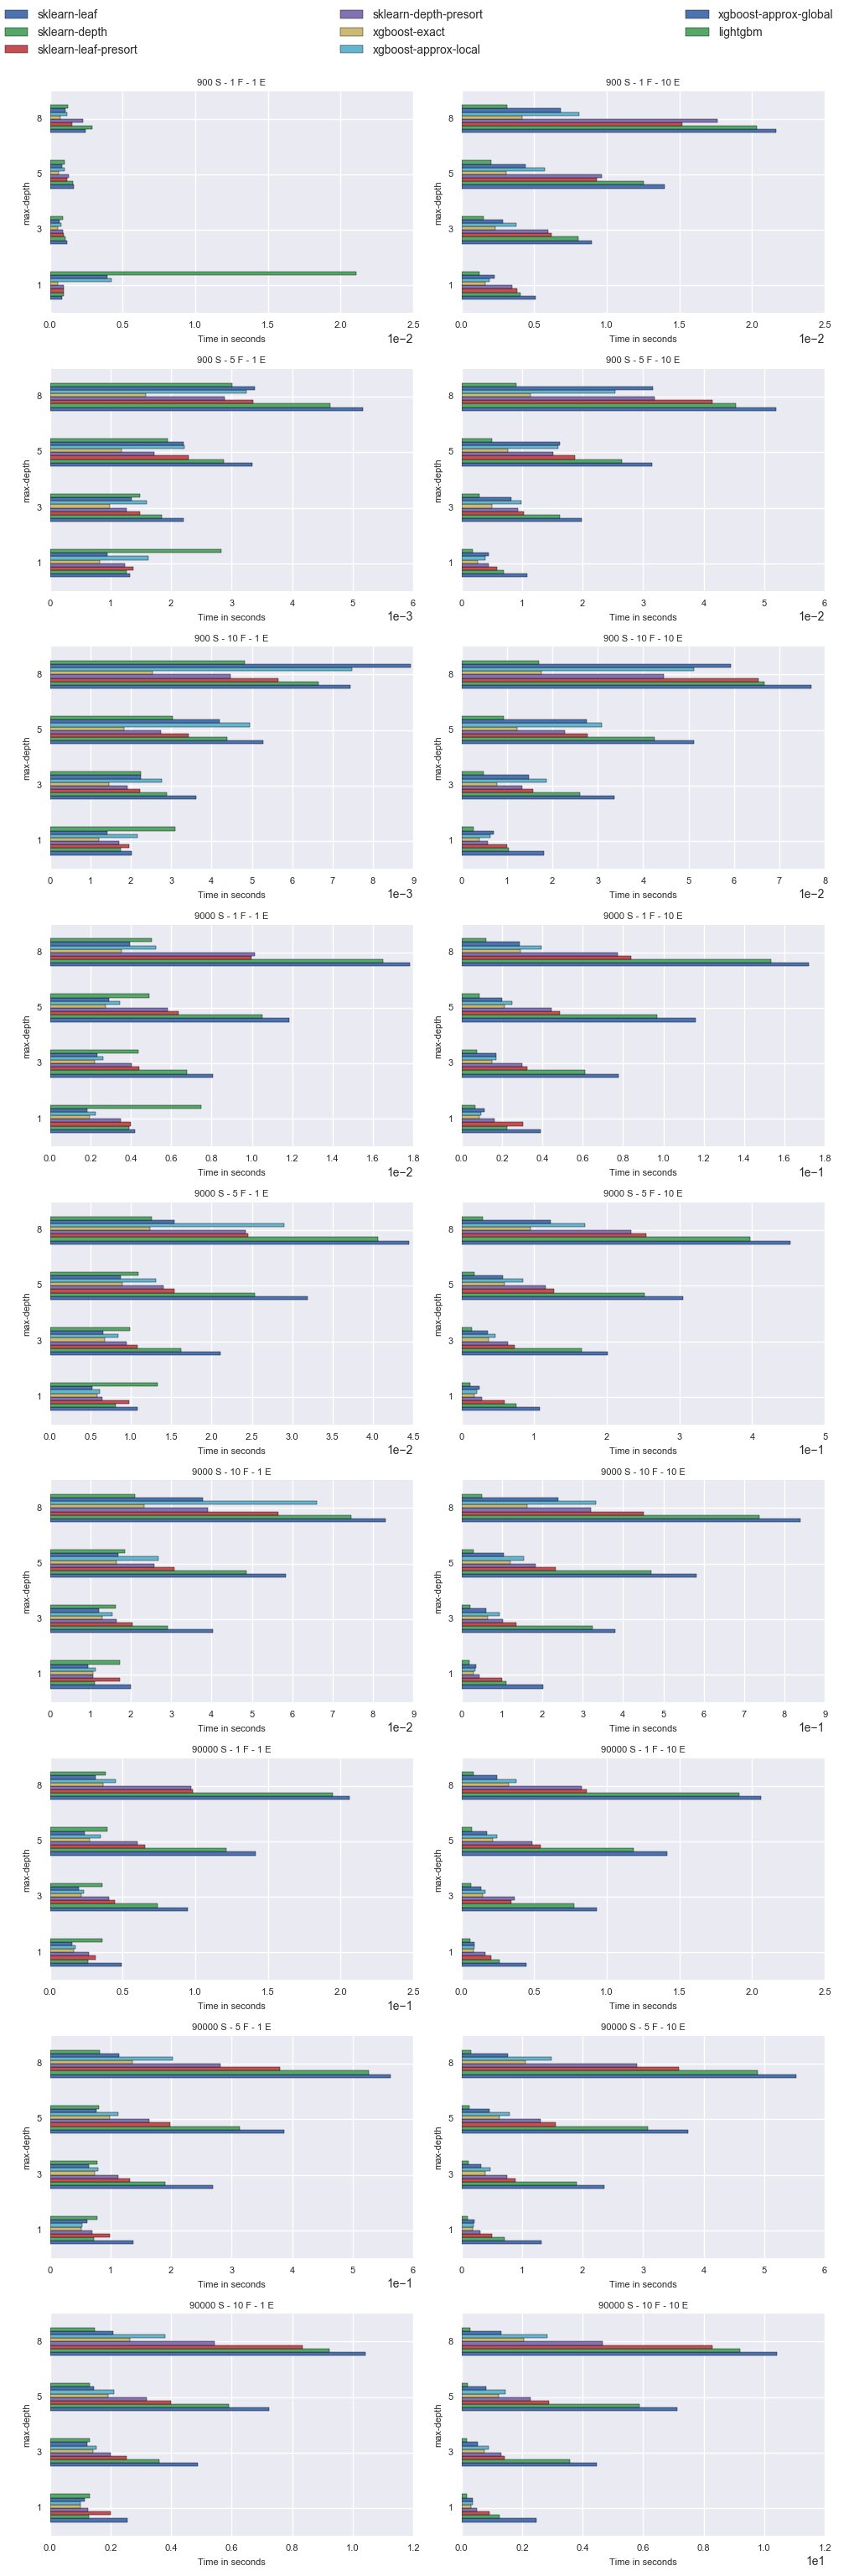

In [6]:
# Create a subplot
nb_plot = 18
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))

# Groupe the data for plotting
grouped_num_samples = df_bench.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            df = ge.set_index('max_depth')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df[bench_name], (ns, nf, ne))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()

## Stacking average pre-processing and fitting time

We want a plot stacking the average and standard deviation for each method. Therefore, the method will be the index while we need to get the other parameters and observations.

### Analysis

* Using a stump tree, `sklearn` is the fastest algrithm with a single tree.
* Adding trees, slow-down `sklearn`.
* With a depth of 3, `sklearn` and `xgboost` are equivalent with a single tree.
* Increasing the depth will increase the time difference of fitting between `sklearn` and `xgboost`, `sklearn` getting slower.
* Increasing the number of samples do not seem to have a drastic influence on the fitting of `sklearn`.
* `xgboost` pre-processing has to be taken into account and is not negligeable.
* The most costing part for `sklearn` is to add new layer in trees.

In [7]:
# Read the benchmark data
data_skl_leaf_presort = misc.load_benchmark_data('results/skl_leaf_with_presort_random.pk')
data_skl_leaf = misc.load_benchmark_data('results/skl_leaf_without_presort_random.pk')
data_skl_depth_presort = misc.load_benchmark_data('results/skl_depth_with_presort_random.pk')
data_skl_depth = misc.load_benchmark_data('results/skl_depth_without_presort_random.pk')

data_xgb_exact = misc.load_benchmark_data('results/xgboost_exact_random.pk')
data_xgb_approx_local = misc.load_benchmark_data('results/xgboost_approx_local_random.pk')
data_xgb_approx_global = misc.load_benchmark_data('results/xgboost_approx_global_random.pk')

data_lgb = misc.load_benchmark_data('results/lightgbm_random.pk', True)

# Group the data in a single list
data_bench = [data_skl_leaf, data_skl_depth, data_skl_leaf_presort, data_skl_depth_presort,
              data_xgb_exact, data_xgb_approx_local, data_xgb_approx_global,
              data_lgb]

In [8]:
# Define which columns need to be selected
col_to_select = ['avg_data_time', 'avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
# We need to add a column to specify which method it is
bench_name = ['sklearn-leaf', 'sklearn-depth', 'sklearn-leaf-presort', 'sklearn-depth-presort',
              'xgboost-exact', 'xgboost-approx-local', 'xgboost-approx-global',
              'lightgbm']
# Select the columns
for idx_bench in range(len(data_bench)):
    data_bench[idx_bench] = data_bench[idx_bench].loc[:, col_to_select]
    data_bench[idx_bench]['toolbox'] = pd.Series(np.array([bench_name[idx_bench]] * len(data_bench[idx_bench])),
                                                 index=data_bench[idx_bench].index)
    # Put the data time to zero if this is sklearn
    if bench_name[idx_bench].startswith('sklearn'):
        data_bench[idx_bench]['avg_data_time'] = 0

df_bench = pd.concat(data_bench)

We need to move the method as index and afterwords perform some grouping before to plot

In [9]:
# Define a plotting function to allow easy tight plot
def pd_df_barh(ax, df, name_params,fontsize=8):
    df.plot.barh(ax=ax, stacked=True, legend=False)
    ax.set_xlabel('Time in seconds', fontsize=fontsize)
    ax.set_ylabel('toolbox', fontsize=fontsize)
    ax.set_title('{} S - {} F - {} E - {} D'.format(*name_params),
                fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
    patches, labels = ax.get_legend_handles_labels()
    return patches, labels

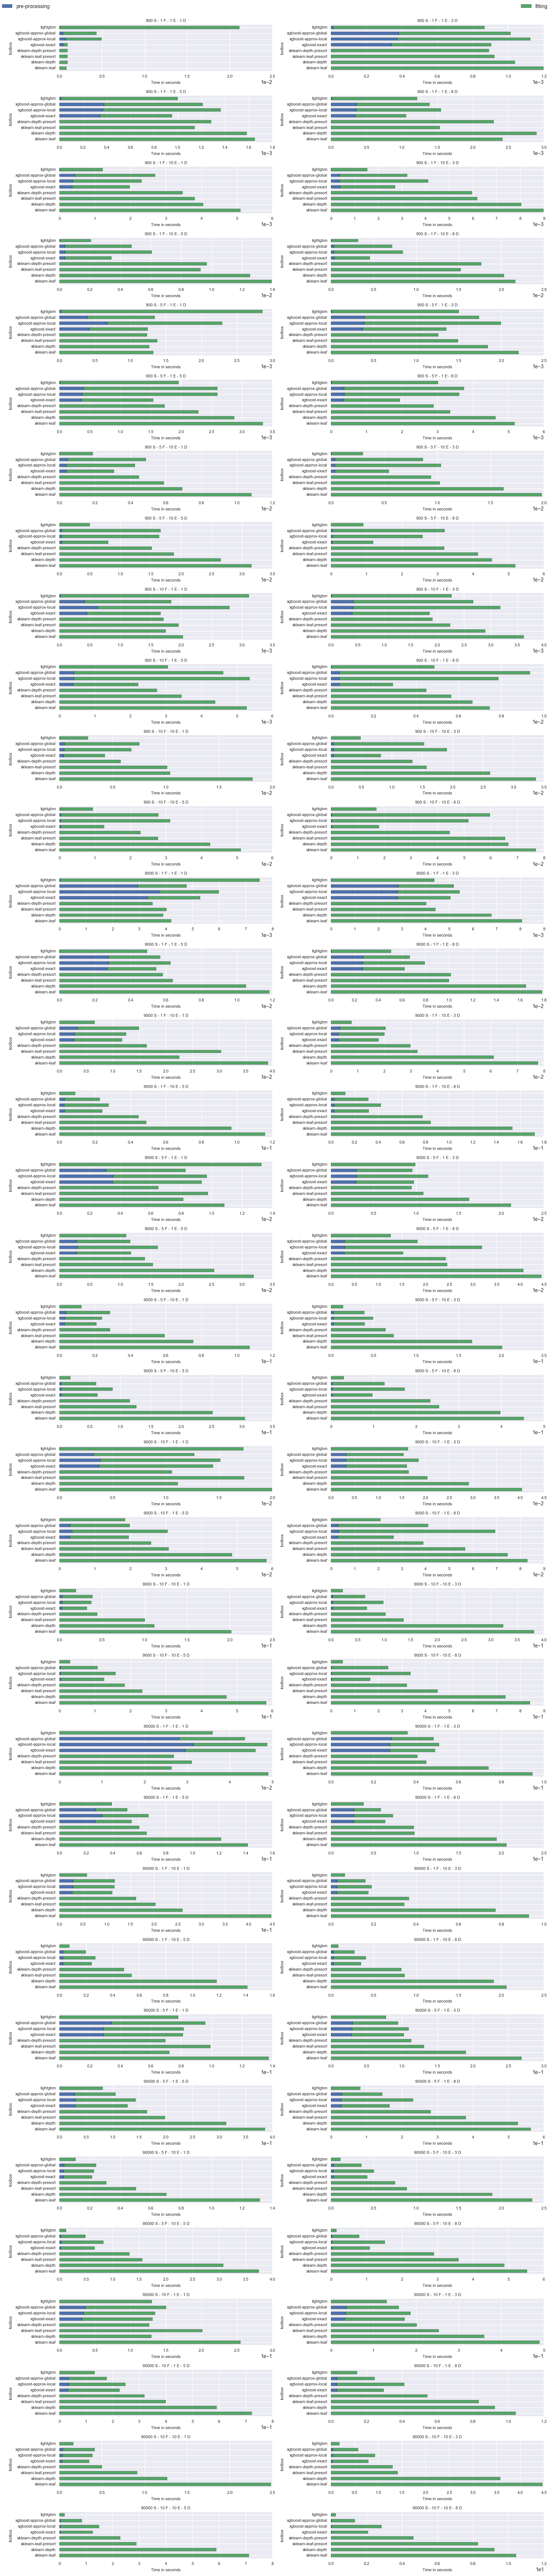

In [10]:
# Create a subplot
nb_plot = len(df_bench) // 8
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 70))

# Group the data
col_interest = ['pre-processing', 'fitting']
# Rename the column for nicer plot
df_bench = df_bench.rename(columns = {'avg_data_time': col_interest[0]})
df_bench = df_bench.rename(columns = {'avg_fit_time': col_interest[1]})
# Group to sort the plots
grouped_num_samples = df_bench.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            grouped_max_depth = ge.groupby('max_depth')
            for nd, gd in grouped_max_depth:
                # Set the inddex of the dataframe
                df = gd.set_index('toolbox')
                # Compute the index of the axis where to plot
                idx_ax = np.unravel_index(nplot, (nrows, ncols))
                # Sent the data to plot by selecting the column of interest
                p, l = pd_df_barh(axs[idx_ax], df[col_interest], (ns, nf, ne, nd))
                nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()

## Relative speed-up of the presorting in scikit-learn

We keep only the scikit-learn bench and we will check how the presorting affect the average fitting time respect to the depth of the trees.

### Analysis

* The speed-up decrease/stable when the depth increases.
* There no additional speed-up after a depth of 3.

In [11]:
# Group the data in a single list
data_bench_leaf = [data_skl_depth, data_skl_depth_presort]
data_bench_depth = [data_skl_depth, data_skl_depth_presort]

# Define which columns need to be selected
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
# Select the columns
for idx_bench in range(len(data_bench_leaf)):
    data_bench_leaf[idx_bench] = data_bench_leaf[idx_bench].loc[:, col_to_select]
    data_bench_depth[idx_bench] = data_bench_depth[idx_bench].loc[:, col_to_select]

# Rename the columns corresponding to the fit time
data_bench_leaf[0] = data_bench_leaf[0].rename(columns = {'avg_fit_time': 'no_presort'})
data_bench_leaf[1] = data_bench_leaf[1].rename(columns = {'avg_fit_time': 'presort'})
data_bench_depth[0] = data_bench_depth[0].rename(columns = {'avg_fit_time': 'no_presort'})
data_bench_depth[1] = data_bench_depth[1].rename(columns = {'avg_fit_time': 'presort'})

# The name of the column to use for the merging
key_merging = ['num_samples', 'num_features', 'max_depth', 'n_estimators']
# Merge the two first bench - keep only the intersection
df_bench_leaf = pd.merge(data_bench_leaf[0], data_bench_leaf[1], on=key_merging, how='inner')
df_bench_depth = pd.merge(data_bench_depth[0], data_bench_depth[1], on=key_merging, how='inner')

# Compute the ratio of no_presort over presort
df_bench_leaf['speed-up'] = df_bench_leaf['no_presort'] / df_bench_leaf['presort']
df_bench_depth['speed-up'] = df_bench_depth['no_presort'] / df_bench_depth['presort']

In [12]:
# Define a plotting function to allow easy tight plot
def pd_df_barh(ax, df, name_params,fontsize=8):
    df.plot.barh(ax=ax, stacked=True, legend=False)
    ax.set_xlabel('Ratio', fontsize=fontsize)
    ax.set_ylabel('max-depth', fontsize=fontsize)
    ax.set_title('{} S - {} F - {} E'.format(*name_params),
                fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
    patches, labels = ax.get_legend_handles_labels()
    return patches, labels

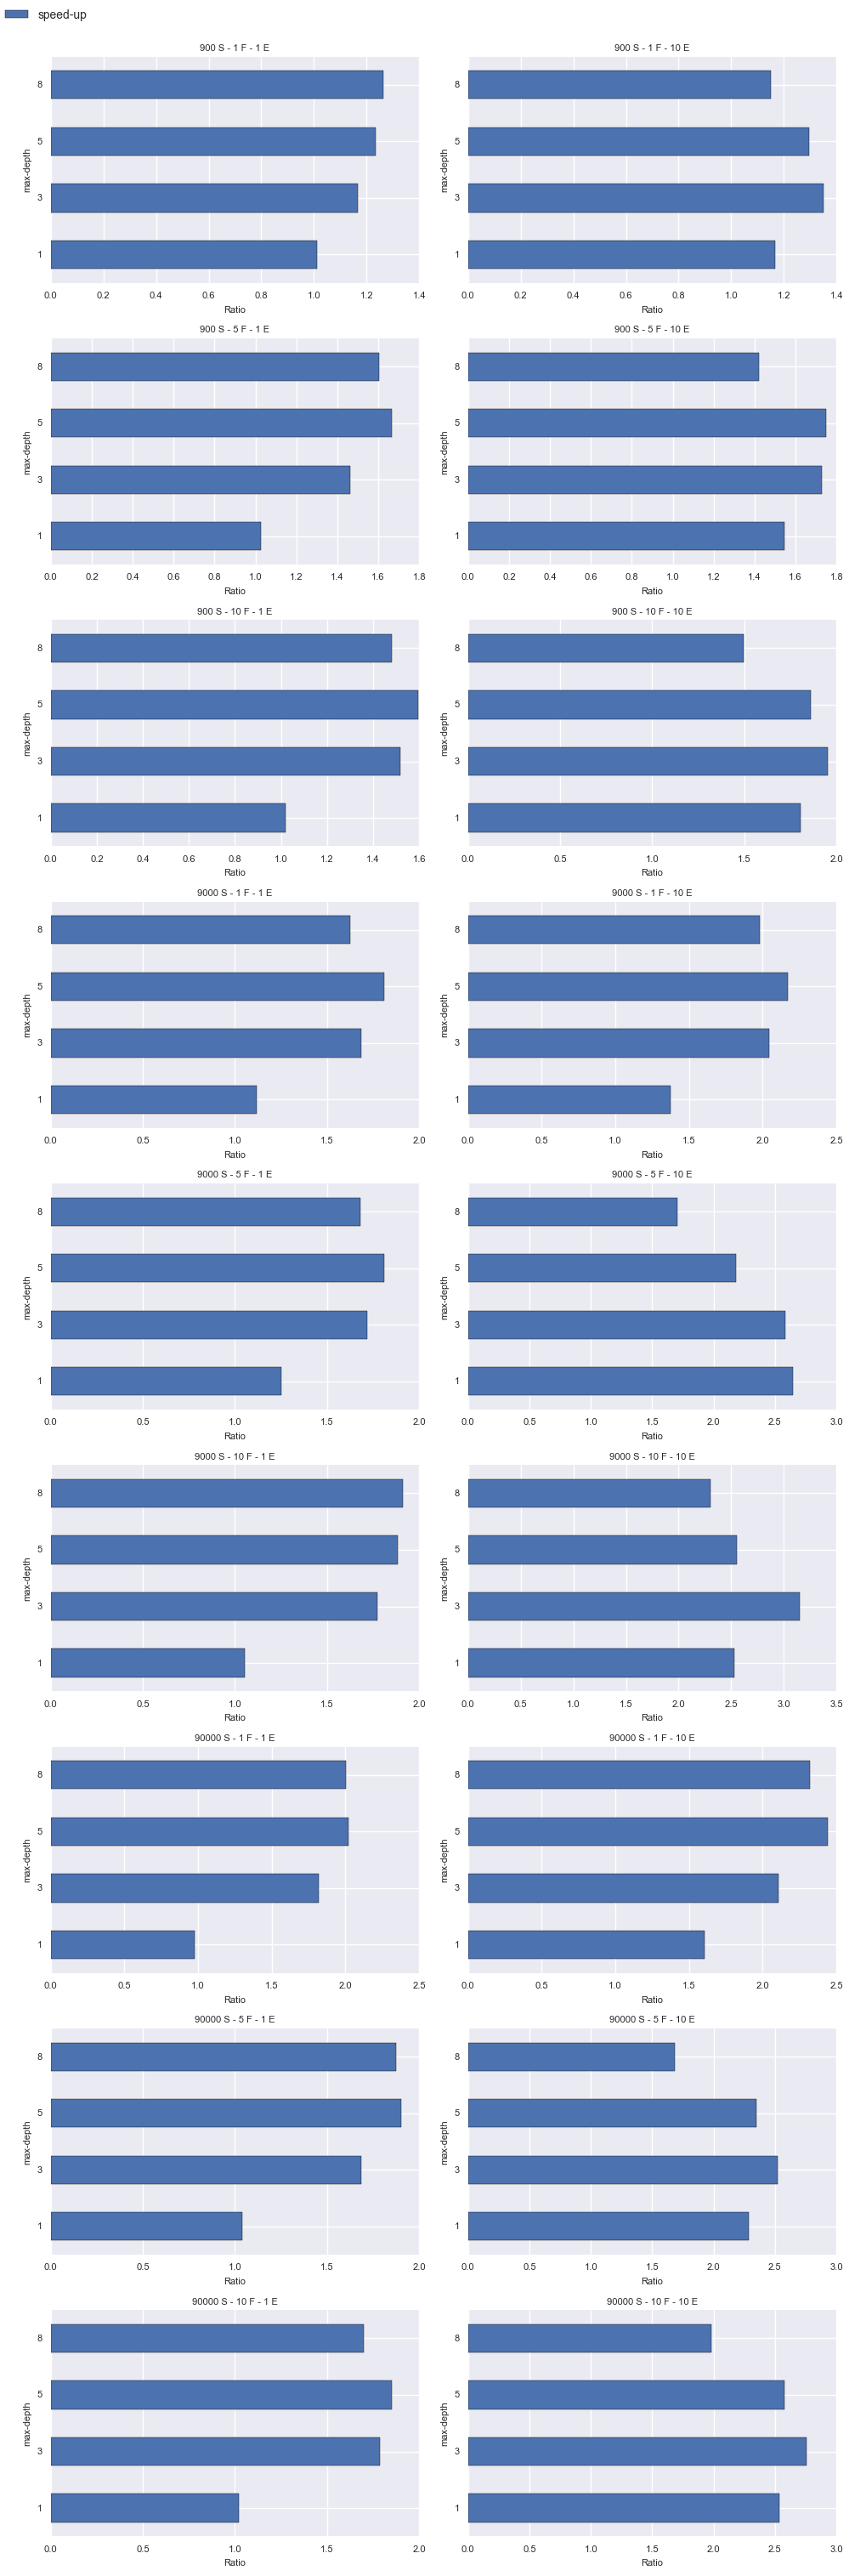

In [13]:
# Create a subplot
nb_plot = 18
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))

# Groupe the data for plotting
grouped_num_samples = df_bench_depth.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            df = ge.set_index('max_depth')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df['speed-up'], (ns, nf, ne))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()

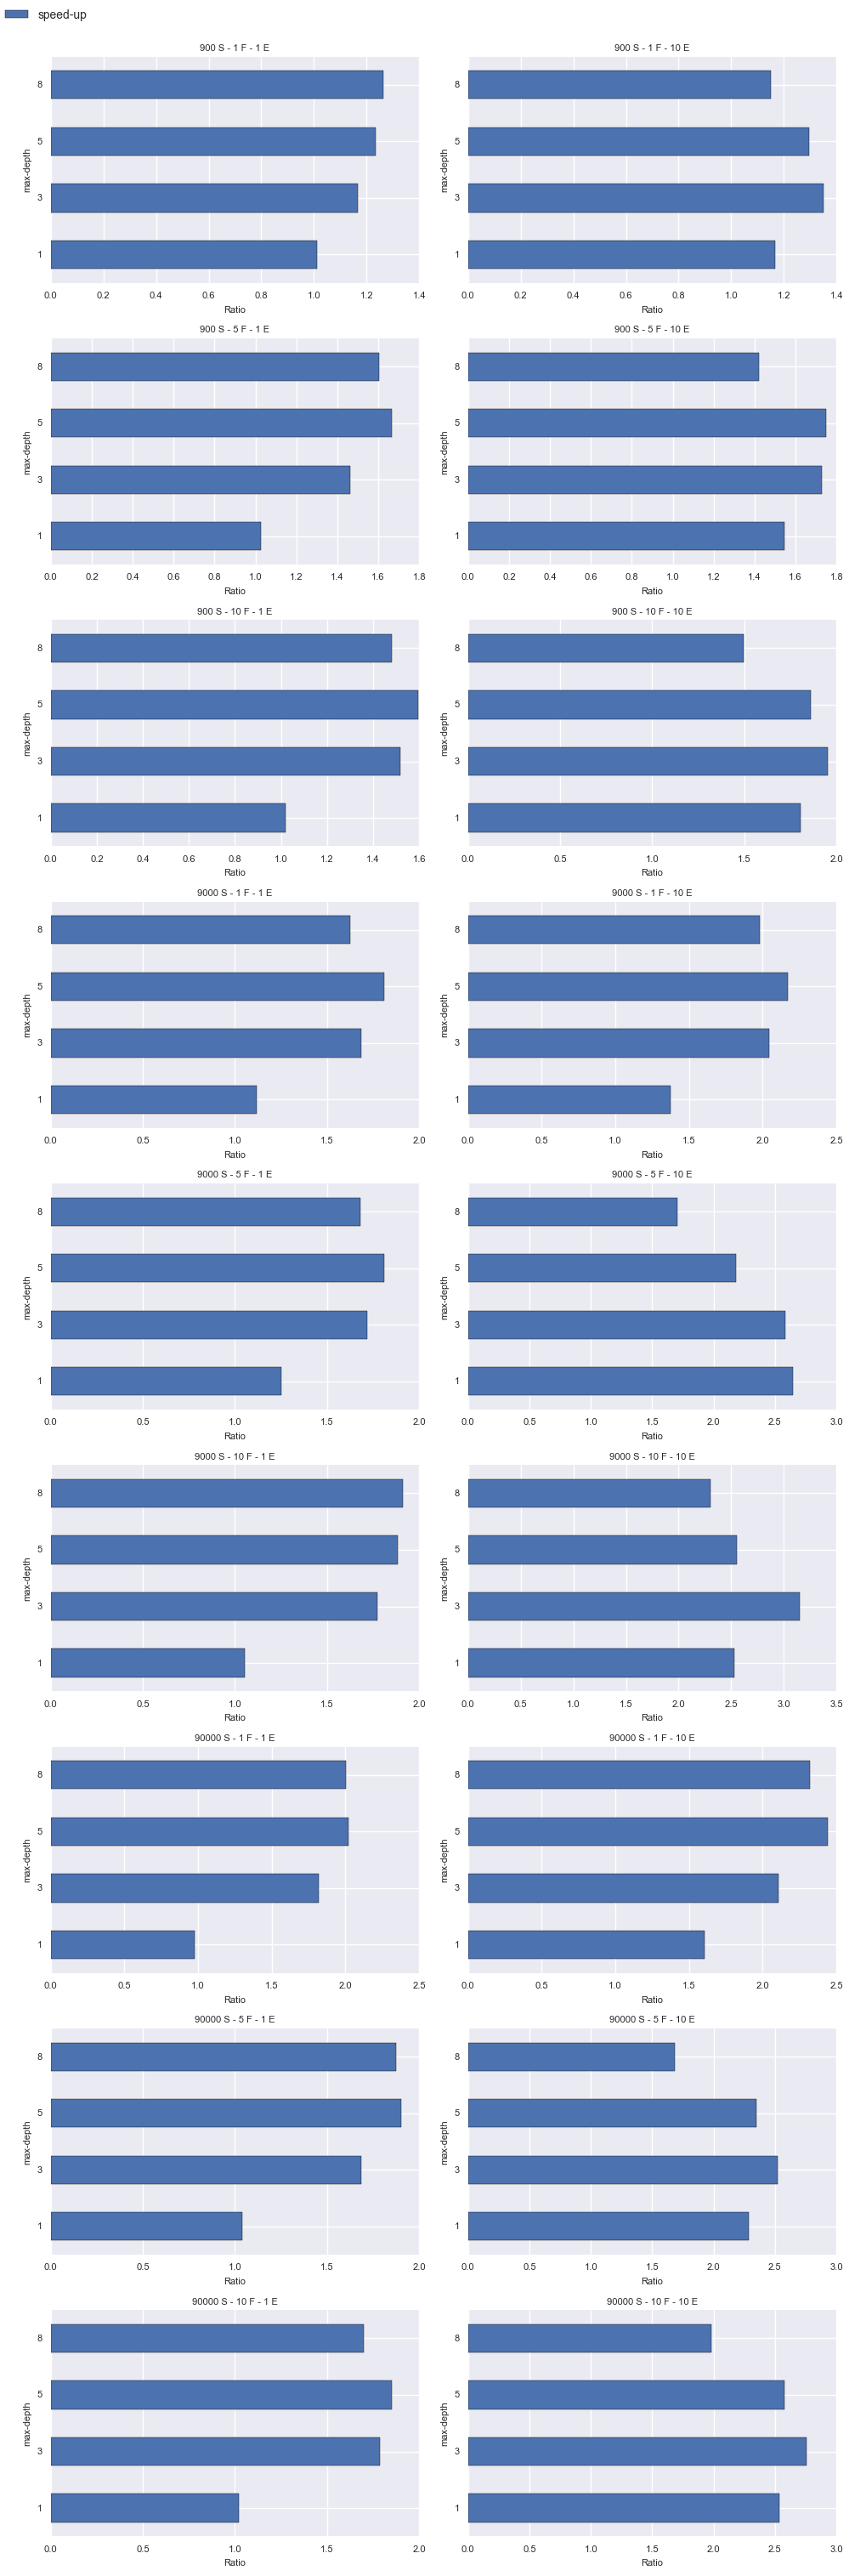

In [14]:
# Create a subplot
nb_plot = 18
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))

# Groupe the data for plotting
grouped_num_samples = df_bench_leaf.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            df = ge.set_index('max_depth')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df['speed-up'], (ns, nf, ne))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()

## Time increase with additional trees

We will check if the fitting time increase from 1 tree to 10 trees has a similar multiplier factor. We do not use the sorted data.

### No presorting

In [15]:
# Define which columns need to be selected
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
df_skl = data_skl_depth.loc[:, col_to_select]

# Group the DataFrame depeding of the number of estimator
grouped_num_estimators = df_skl.groupby('n_estimators')

# Create a list DataFrame and exclude the number of estimators
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth']
data_bench = [ge.loc[:, col_to_select] for ne, ge in grouped_num_estimators]

# Rename the columns corresponding to the fit time
data_bench[0] = data_bench[0].rename(columns = {'avg_fit_time': 'fit_time_est_1'})
data_bench[1] = data_bench[1].rename(columns = {'avg_fit_time': 'fit_time_est_10'})

# The name of the column to use for the merging
key_merging = ['num_samples', 'num_features', 'max_depth']
# Merge the two first bench - keep only the intersection
df_bench = pd.merge(data_bench[0], data_bench[1], on=key_merging, how='inner')

# Compute the ratio 10/1 estimators
df_bench['ratio_10_1'] = df_bench['fit_time_est_10'] / df_bench['fit_time_est_1']

In [16]:
# Define a plotting function to allow easy tight plot
def pd_df_barh(ax, df, name_params,fontsize=8):
    df.plot.barh(ax=ax, stacked=True, legend=False)
    ax.set_xlabel('Ratio', fontsize=fontsize)
    ax.set_ylabel('max-depth', fontsize=fontsize)
    ax.set_title('{} S - {} F'.format(*name_params),
                fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
    patches, labels = ax.get_legend_handles_labels()
    return patches, labels

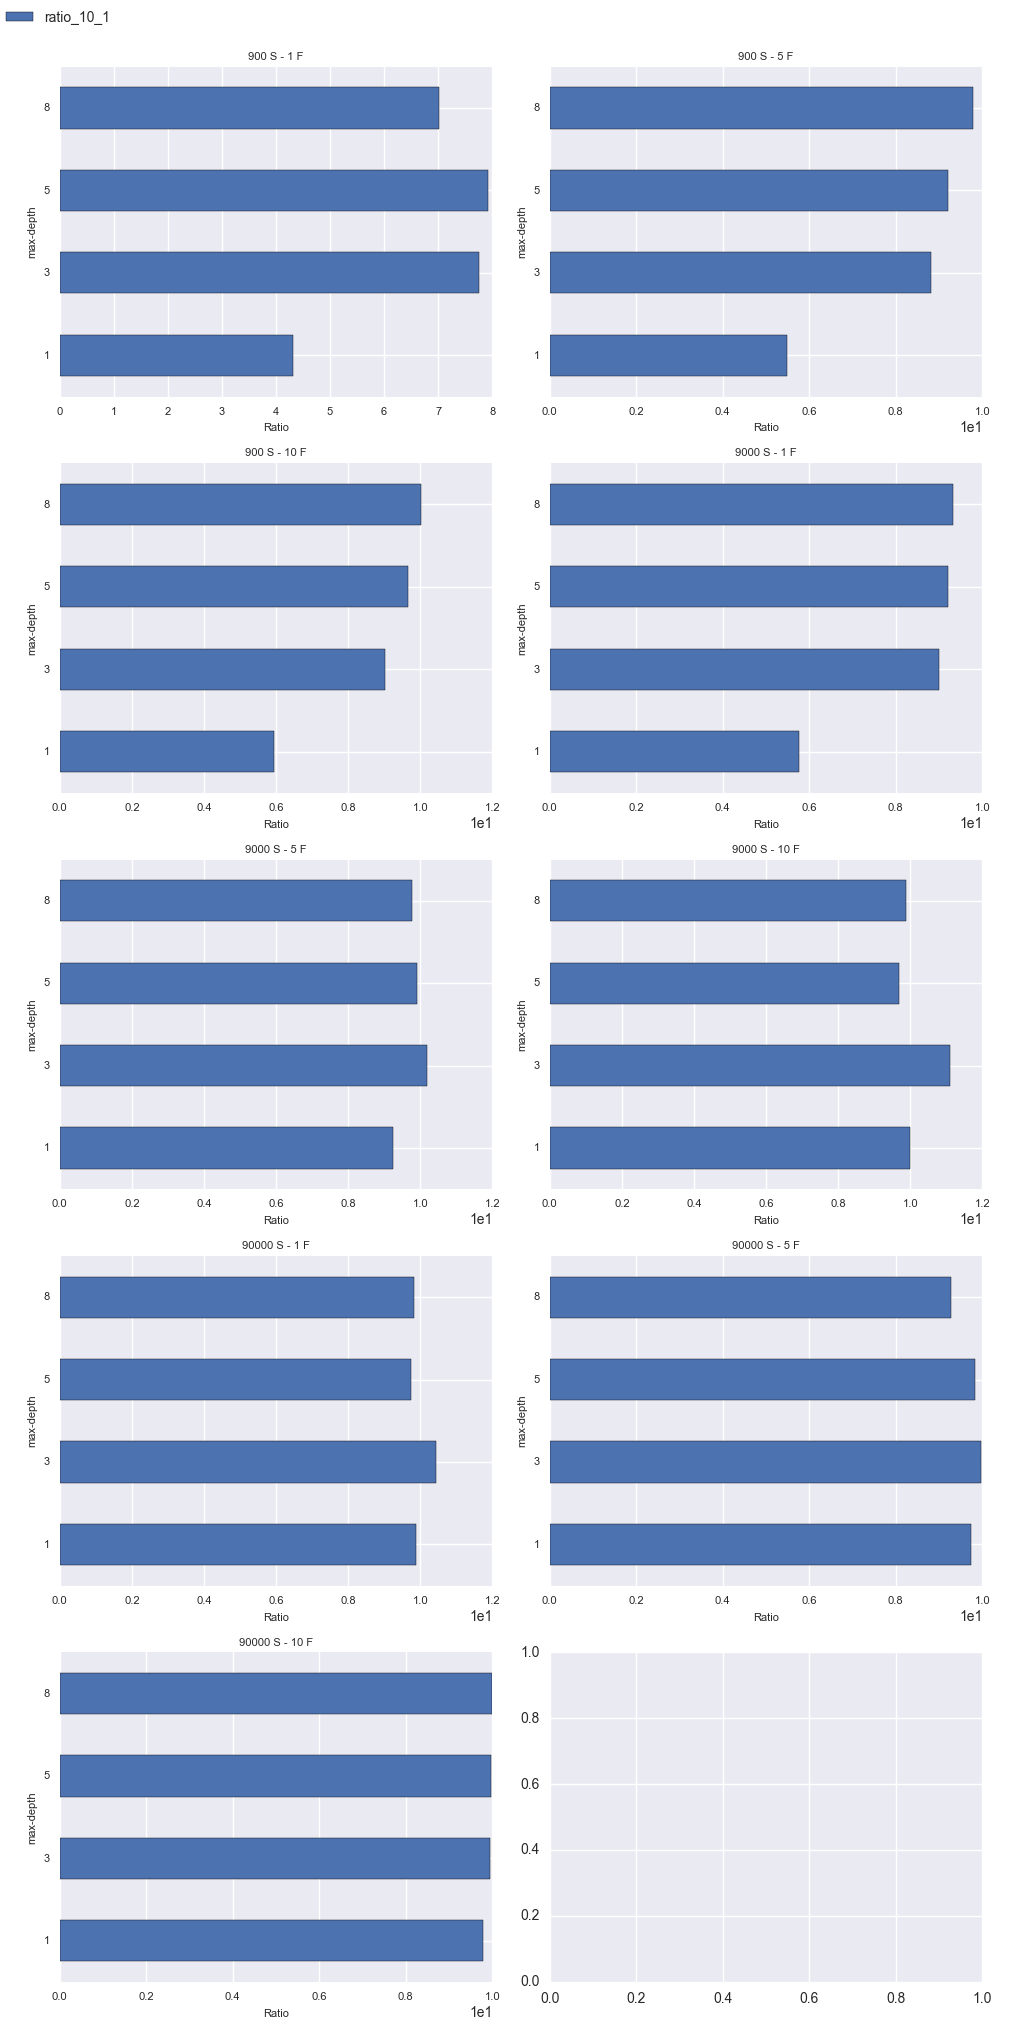

In [17]:
# Create a subplot
nb_plot = 9
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))

# Groupe the data for plotting
grouped_num_samples = df_bench.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
            df = gf.set_index('max_depth')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df['ratio_10_1'], (ns, nf))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()

### Persorting

In [18]:
# Define which columns need to be selected
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
df_skl = data_skl_depth_presort.loc[:, col_to_select]

# Group the DataFrame depeding of the number of estimator
grouped_num_estimators = df_skl.groupby('n_estimators')

# Create a list DataFrame and exclude the number of estimators
col_to_select = ['avg_fit_time', 'num_samples', 'num_features', 'max_depth']
data_bench = [ge.loc[:, col_to_select] for ne, ge in grouped_num_estimators]

# Rename the columns corresponding to the fit time
data_bench[0] = data_bench[0].rename(columns = {'avg_fit_time': 'fit_time_est_1'})
data_bench[1] = data_bench[1].rename(columns = {'avg_fit_time': 'fit_time_est_10'})

# The name of the column to use for the merging
key_merging = ['num_samples', 'num_features', 'max_depth']
# Merge the two first bench - keep only the intersection
df_bench = pd.merge(data_bench[0], data_bench[1], on=key_merging, how='inner')

# Compute the ratio 10/1 estimators
df_bench['ratio_10_1'] = df_bench['fit_time_est_10'] / df_bench['fit_time_est_1']

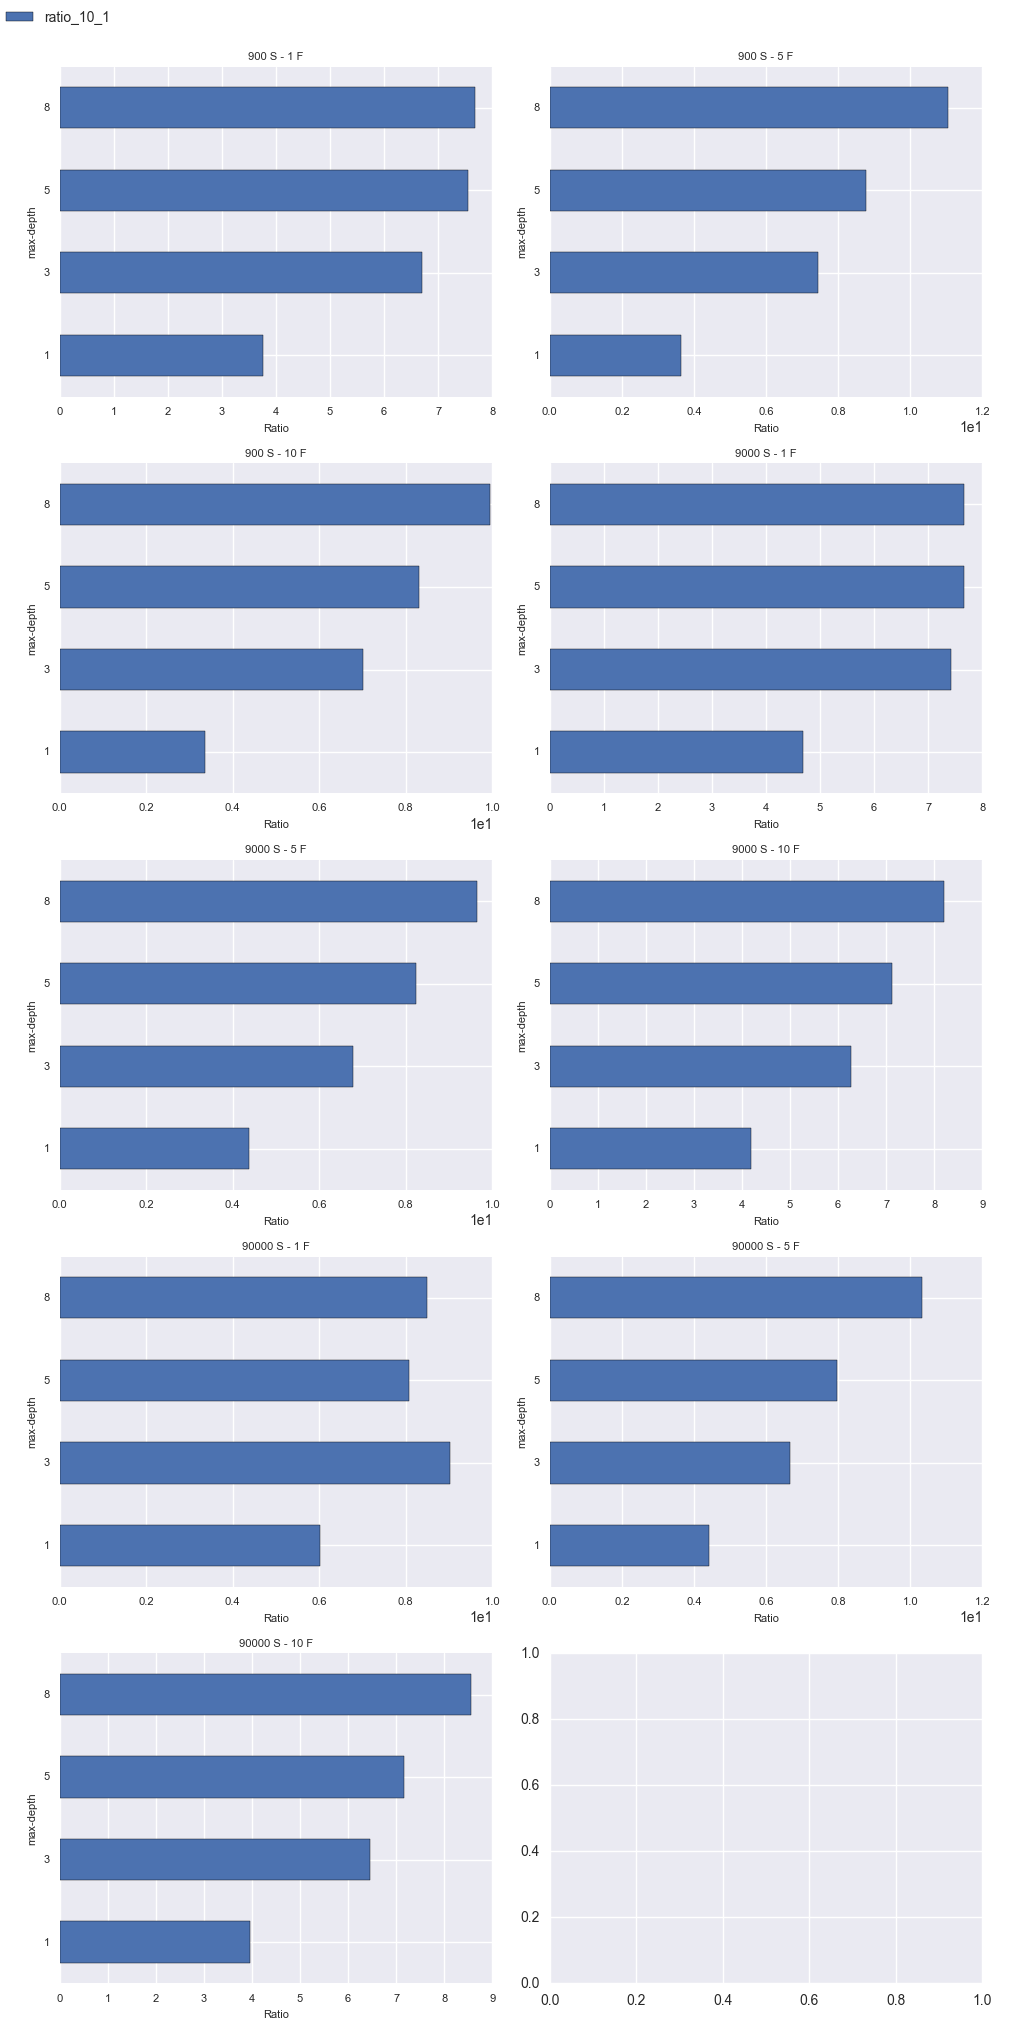

In [19]:
# Create a subplot
nb_plot = 9
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))

# Groupe the data for plotting
grouped_num_samples = df_bench.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
            df = gf.set_index('max_depth')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df['ratio_10_1'], (ns, nf))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
plt.tight_layout()

## Higgs dataset

In [24]:
# Read the benchmark data
data_skl_leaf_tricked = misc.load_benchmark_data('results/higgs/skl_tricked_leaf_with_presort_higgs.pk')
data_skl_leaf = misc.load_benchmark_data('results/higgs/skl_leaf_with_presort_higgs.pk')
data_skl_depth_tricked = misc.load_benchmark_data('results/higgs/skl_tricked_depth_with_presort_higgs.pk')
data_skl_depth = misc.load_benchmark_data('results/higgs/skl_depth_with_presort_higgs.pk')

data_xgb_exact = misc.load_benchmark_data('results/higgs/xgboost_exact_higgs.pk')
data_xgb_exact_nocache = misc.load_benchmark_data('results/higgs/xgboost_exact_nocache_higgs.pk')
data_xgb_approx_local = misc.load_benchmark_data('results/higgs/xgboost_approx_local_higgs.pk')
data_xgb_approx_global = misc.load_benchmark_data('results/higgs/xgboost_approx_global_higgs.pk')

data_lgb = misc.load_benchmark_data('results/higgs/lightgbm_higgs.pk', True)

# Group the data in a single list
data_bench = [data_skl_leaf, data_skl_depth, data_skl_leaf_tricked, data_skl_depth_tricked,
              data_xgb_exact, data_xgb_exact_nocache, data_xgb_approx_local, data_xgb_approx_global, data_lgb]

In [25]:
# Define which columns need to be selected
col_to_select = ['avg_data_time', 'avg_fit_time', 'num_samples', 'num_features', 'max_depth', 'n_estimators']
# We need to add a column to specify which method it is
bench_name = ['sklearn-leaf', 'sklearn-depth', 'sklearn-leaf-tricked', 'sklearn-depth-tricked',
              'xgboost-exact', 'xgboost-exact-nocache', 'xgboost-approx-local', 'xgboost-approx-global', 'lightgbm']
# Select the columns
for idx_bench in range(len(data_bench)):
    data_bench[idx_bench] = data_bench[idx_bench].loc[:, col_to_select]
    data_bench[idx_bench]['toolbox'] = pd.Series(np.array([bench_name[idx_bench]] * len(data_bench[idx_bench])),
                                                 index=data_bench[idx_bench].index)

df_bench = pd.concat(data_bench)

In [26]:
# Define a plotting function to allow easy tight plot
def pd_df_barh(ax, df, name_params,fontsize=8):
    df.plot.barh(ax=ax, stacked=True, legend=False)
    ax.set_xlabel('Time in seconds', fontsize=fontsize)
    ax.set_ylabel('toolbox', fontsize=fontsize)
    ax.set_title('{} S - {} E - {} D'.format(*name_params),
                fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.xaxis.get_major_formatter().set_powerlimits((0, 1))
    patches, labels = ax.get_legend_handles_labels()
    return patches, labels

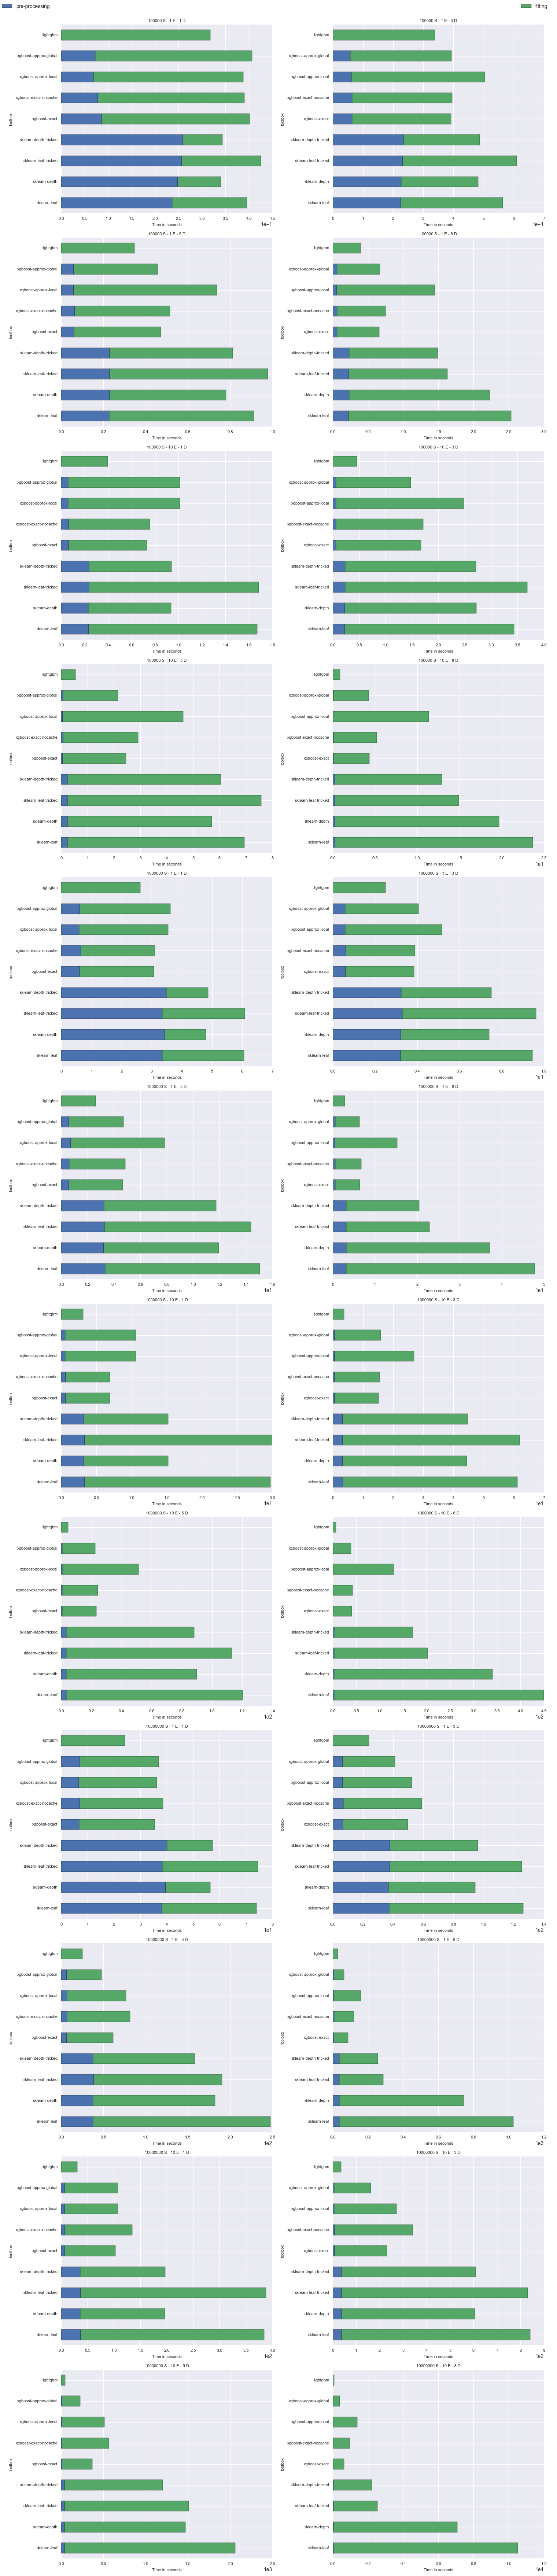

In [27]:
# Create a subplot
nb_plot = len(df_bench) // 9
ncols = 2
nrows = int(np.ceil(nb_plot / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 70))

# Group the data
col_interest = ['pre-processing', 'fitting']
# Rename the column for nicer plot
df_bench = df_bench.rename(columns = {'avg_data_time': col_interest[0]})
df_bench = df_bench.rename(columns = {'avg_fit_time': col_interest[1]})
# Group to sort the plots
grouped_num_samples = df_bench.groupby('num_samples')
nplot = 0
for ns, gs in grouped_num_samples:
    grouped_num_estimators = gs.groupby('n_estimators')
    for ne, ge in grouped_num_estimators:
        grouped_max_depth = ge.groupby('max_depth')
        for nd, gd in grouped_max_depth:
            # Set the inddex of the dataframe
            df = gd.set_index('toolbox')
            # Compute the index of the axis where to plot
            idx_ax = np.unravel_index(nplot, (nrows, ncols))
            # Sent the data to plot by selecting the column of interest
            p, l = pd_df_barh(axs[idx_ax], df[col_interest], (ns, ne, nd))
            nplot += 1
fig.legend(p, l, bbox_to_anchor=(0., 1., 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()

# Dirty stuff - don't look at it

Sort the `DataFrame` just in case

In [ ]:
print(len(df_bench))


In [ ]:
grouped = data_skl.groupby('max_depth')

for name, group in grouped:
    print(name)
    print(group)

Create plenty of `DataFrame` by selecting samples by criterion

In [ ]:
# Group all the DataFrame together
data_bench = [data_skl, data_xgb, data_lgb]

To later split/group the graph, we can find the set of parameters used

In [ ]:
# Find the unique parameters
conf_num_samples = data_bench[0].num_samples.unique()
conf_num_features = data_bench[0].num_features.unique()
conf_max_depth = data_bench[0].max_depth.unique()
conf_n_estimators = data_bench[0].n_estimators.unique()

print('The number of samples tested are: {}'.format(conf_num_samples))
print('The number of features tested are: {}'.format(conf_num_features))
print('The maximum depth tested are: {}'.format(conf_max_depth))
print('The number of estimators tested are: {}'.format(conf_n_estimators))

### Extract the average time information

We extract the average time for the fitting for the different methods and put them in a DataFrame.
We keep also the different parameters.

In [ ]:
avg_fit_time = np.zeros((data_skl.shape[0], 3))
for i in range(data_skl.shape[0]):
    # We need to get the configuration of interest
    num_samples = data_bench[0].loc[i, 'num_samples']
    num_features = data_bench[0].loc[i, 'num_features']
    max_depth = data_bench[0].loc[i, 'max_depth']
    n_estimators = data_bench[0].loc[i, 'n_estimators']
    
    # Build a list with all those variables
    col_name = ['num_samples', 'num_features', 'max_depth', 'n_estimators']
    col_val = [num_samples, num_features, max_depth, n_estimators]
    
    # Build the string for the query
    query_str = ''
    for var in range(len(col_name)):
        query_str += ' {} == {} &'.format(col_name[var], col_val[var])
    # Remove teh last &
    query_str = query_str[:-1]
    
    # Make the query
    col_to_select = ['avg_fit_time','num_samples', 'num_features', 'max_depth', 'n_estimators']
    for j in range(len(data_bench)):
        avg_fit_time[i, j] = data_bench[j].query(query_str).loc[:, col_to_select]

# Create a DataFrame with the time information
avg_fit_time_df = pd.DataFrame(avg_fit_time, columns=['sklearn', 'xgboost', 'lightgbm'])

In [ ]:
print(data_bench[0].sort_values(col_name))

In [ ]:
# Make an horizontal plot of the different time
avg_fit_time_df.plot.barh(stacked=True, figsize=(15, 20))

In [ ]:
grouped_num_samples = df_bench.groupby('num_samples')
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            df = ge.set_index('max_depth')
            df[bench_name].plot.barh()
            plt.xlabel('Time in sec')
            plt.title('Parameters: {} samples - {} features - {} estimators'.format(ns, nf, ne),
                      y=1.15)
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)

In [ ]:
col_interest = ['pre-processing', 'fitting']
# Rename the column for nicer plot
df_bench = df_bench.rename(columns = {'avg_data_time': col_interest[0]})
df_bench = df_bench.rename(columns = {'avg_fit_time': col_interest[1]})
# Group to sort the plots
grouped_num_samples = df_bench.groupby('num_samples')
for ns, gs in grouped_num_samples:
    grouped_num_features = gs.groupby('num_features')
    for nf, gf in grouped_num_features:
        grouped_num_estimators = gf.groupby('n_estimators')
        for ne, ge in grouped_num_estimators:
            grouped_max_depth = ge.groupby('max_depth')
            for nd, gd in grouped_max_depth:
                df = gd.set_index('toolbox')
                df[col_interest].plot.barh(stacked=True)
                plt.xlabel('Time in sec')
                plt.title('Parameters: {} samples - {} features - {} estimators - {} max-depth'.format(ns, nf, ne, nd),
                          y=1.15)
                plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)